# Playa Events:  Exploratory Data Analysis

#### Outline

- How are events distributed by time? (By Day, By Hour)
- How are events distributed by type?
- Who are the most active camps?
- What are the most common words in event descriptions?
- How are events distributed by location?
- Can we construct an event classifier?

In [1]:
import pandas as pd;
import numpy as np;
import seaborn as sns;
import matplotlib.pyplot as plt;
import numpy as np;

%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer

import nltk, re, pprint
from nltk.corpus   import stopwords
from nltk          import word_tokenize
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from wordcloud import WordCloud, STOPWORDS

import random;
import matplotlib as mpl;

from pylab import *;

Import data from Justin Klein's spreadsheet of events at Burning Man 2017, 2016, and 2015

http://www.justin-klein.com/playaevents-excel-exporter/

In [2]:
col_names_17 = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday2', 'Monday2', 
                'Title', 'Description', 'Type', 'Camp', 'Where', 'Extra', 'Link']

df_17 = pd.read_excel('PlayaEvents-2017.xlsx', names=col_names_17, skip_footer=2);

df_17.describe()

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday2,Monday2,Title,Description,Type,Camp,Where,Extra,Link
count,3680,3680,3680,3680,3680,3680,3680,3680,3680,3680,3679,3680,3680,3678,3679,3680
unique,120,275,317,329,326,309,207,106,36,3577,3602,13,559,408,537,3647
top,-,-,-,-,-,-,-,-,-,Freetown Christiania,The PlayaPops is glad to offer its fourth seas...,work,-,Open Playa,-,-
freq,3168,2478,2170,2090,2165,2339,2888,3206,3331,5,6,1110,543,269,2604,33


In [3]:
col_names_16 = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday2', 'Monday2', 
                'Title', 'Description', 'Type', 'Camp', 'Where', 'Extra', 'Link']

df_16 = pd.read_excel('PlayaEvents-2016.xlsx', names=col_names_16, skip_footer=2);

# add empty entries for Sunday, for consistency between all DFs
df_16['Sunday'] = '-'

df_16 = df_16[['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday2', 'Monday2', 
               'Title', 'Description', 'Type', 'Camp', 'Where', 'Extra', 'Link']]

df_16.describe()

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday2,Monday2,Title,Description,Type,Camp,Where,Extra,Link
count,3443,3443,3443,3443,3443,3443,3443,3443,3443,3443,3443,3443,3443,3443,3443,3443
unique,1,231,283,303,290,259,190,97,21,3259,3304,13,543,415,564,3427
top,-,-,-,-,-,-,-,-,-,The Orgasamator Experience,The legendary Orgasmatron first came to the pl...,work,-,-,-,-
freq,3443,2406,2059,1982,2012,2239,2663,2981,3140,7,7,1065,457,288,2090,17


In [4]:
col_names_15 = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday2', 'Monday2', 
                'Camp', 'Type', 'Title', 'Description', 'Where', 'Where (Unofficial)', 'Link']

df_15 = pd.read_excel('PlayaEvents-2015.xlsx', names=col_names_15, skip_footer=2);

# add empty entries for Sunday, for consistency between all DFs
df_15['Sunday'] = '-'

df_15 = df_15[['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday2', 'Monday2', 
                'Camp', 'Type', 'Title', 'Description', 'Where', 'Where (Unofficial)', 'Link']]

df_15.describe()

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday2,Monday2,Camp,Type,Title,Description,Where,Where (Unofficial),Link
count,2956,2956,2956,2956,2956,2956,2956,2956,2956,2956,2956,2956,2956,2956,2956,2956
unique,1,208,268,287,289,271,177,91,24,506,12,2626,2674,399,216,2956
top,-,-,-,-,-,-,-,-,-,Naked Heart,work,ARRGH BAR - GALLAVANT,Biodanza has been baring hearts since the 60's...,-,-,http://playaevents.burningman.org/2015/playa_e...
freq,2956,2290,1895,1844,1851,2043,2438,2739,2909,219,1029,11,13,2135,821,1


In [25]:
df_17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3680 entries, 0 to 3679
Data columns (total 16 columns):
Sunday         3680 non-null object
Monday         3680 non-null object
Tuesday        3680 non-null object
Wednesday      3680 non-null object
Thursday       3680 non-null object
Friday         3680 non-null object
Saturday       3680 non-null object
Sunday2        3680 non-null object
Monday2        3680 non-null object
Title          3680 non-null object
Description    3679 non-null object
Type           3680 non-null object
Camp           3680 non-null object
Where          3678 non-null object
Extra          3679 non-null object
Link           3680 non-null object
dtypes: object(16)
memory usage: 460.1+ KB


What does the data look like?

In [26]:
df_17.tail()

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday2,Monday2,Title,Description,Type,Camp,Where,Extra,Link
3675,All,All,All,All,All,All,All,All,All,Shrine de Vine,Shrine de Vine is a nature and architecturally...,Art,-,Open Playa,http://elizabethmarley.com,http://burningman.org/event/brc/2017-art-insta...
3676,All,All,All,All,All,All,All,All,All,The Bear,Large burningmanesque bear. Contains the poem ...,Art,-,Open Playa,-,http://burningman.org/event/brc/2017-art-insta...
3677,All,All,All,All,All,All,All,All,All,WeScream,a grounded whimsical ice cream cone made of mi...,Art,-,-,-,-
3678,All,All,All,All,All,All,All,All,All,Rhythmic Ritual Of Love,Rhythmic Ritual Of Love incorporates the most ...,Art,-,Open Playa,-,http://burningman.org/event/brc/2017-art-insta...
3679,All,All,All,All,All,All,All,All,All,Solaris,"Solaris stands as a large, colorfully painted ...",Art,-,Open Playa,-,http://burningman.org/event/brc/2017-art-insta...


In [27]:
df_16.tail()

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday2,Monday2,Title,Description,Type,Camp,Where,Extra,Link
3438,-,All,All,All,All,All,All,All,All,Flocons,Flocons is a dynamic and evolving series of la...,Art,-,-,http://www.dustyvisions.org/current-projects/f...,http://burningman.org/event/brc/2016-art-insta...
3439,-,All,All,All,All,All,All,All,All,The Pork Chop Nebula 2.0,"So the Art project ""Pork Chop Nebula"" is a con...",Art,-,Open Playa,-,http://burningman.org/event/brc/2016-art-insta...
3440,-,All,All,All,All,All,All,All,All,MirrorrorriM,MirrorrorriM is a kaleidoscope the size of a s...,Art,-,Open Playa,http://flockarts.com,http://burningman.org/event/brc/2016-art-insta...
3441,-,All,All,All,All,All,All,All,All,The Black Rock Lighthouse Service,A crystal like cluster of Lighthouses ranging ...,Art,-,Open Playa,http://brlighthouse.org/,http://burningman.org/event/brc/2016-art-insta...
3442,-,All,All,All,All,All,All,All,All,Helios,In resonance with the Leonardo’s Renaissance -...,Art,-,-,-,http://burningman.org/event/brc/2016-art-insta...


In [28]:
df_15.tail()

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday2,Monday2,Camp,Type,Title,Description,Where,Where (Unofficial),Link
2951,-,-,-,16:30-17:45,-,-,-,-,-,Alternative Energy Zone,prty,Solo Burners Meetup,Are you camping and attending Burning Man on y...,In AEZ village in Camp Skylark,3:30 & Ersatz,http://playaevents.burningman.org/2015/playa_e...
2952,-,-,-,08:00-09:30,-,-,-,-,-,Naked Heart,work,Naked Heart Care Yoga,This Yoga Class has its focus in the Heart Cha...,-,6:40 & Geek,http://playaevents.burningman.org/2015/playa_e...
2953,-,-,-,21:00-02:00,-,-,-,-,-,Stag Camp 9,prty,Goth Night 2.0,"While everyone else is enjoying white parties,...",8:15 and D,8:15 & Donniker,http://playaevents.burningman.org/2015/playa_e...
2954,-,-,-,17:00-21:00,-,-,-,-,-,Stag Camp 9,prty,Hateful Happy Hour!,Stag Camp's own Replacement wants to host the ...,8:15 and D,8:15 & Donniker,http://playaevents.burningman.org/2015/playa_e...
2955,-,-,-,-,-,11:00-12:30,-,-,-,Naked Heart,work,Harness the Vital Source Qigong,"Cultivate your natural state of health, vitali...",-,6:40 & Geek,http://playaevents.burningman.org/2015/playa_e...


Let's take a look at the event distribution by day. The middle of the week (Wednesday) seems to be the busiest. Makes sense. Early in the week people are still arriving and setting things up. Later in the week people get into party mode, and then pack out. Note that there were no Sunday events recorded in 2015 and 2016. The number of recorded events has been substantially increasing over these three years, an approximately 43% increase in 2016 and a 15% increase in 2017.

In [50]:
print('Number of Events in 2015: ' + str(counts_15['count'].values.sum()))
print('Number of Events in 2016: ' + str(counts_16['count'].values.sum()))
print('Number of Events in 2017: ' + str(counts_17['count'].values.sum()))

Number of Events in 2015: 5639
Number of Events in 2016: 8062
Number of Events in 2017: 9285


In [52]:
print('Percentage Growth over 2016/2015: ' + str(100*counts_16['count'].values.sum()/counts_15['count'].values.sum()))
print('Percentage Growth over 2017/2016: ' + str(100*counts_17['count'].values.sum()/counts_16['count'].values.sum()))

Percentage Growth over 2016/2015: 142.968611456
Percentage Growth over 2017/2016: 115.169933019


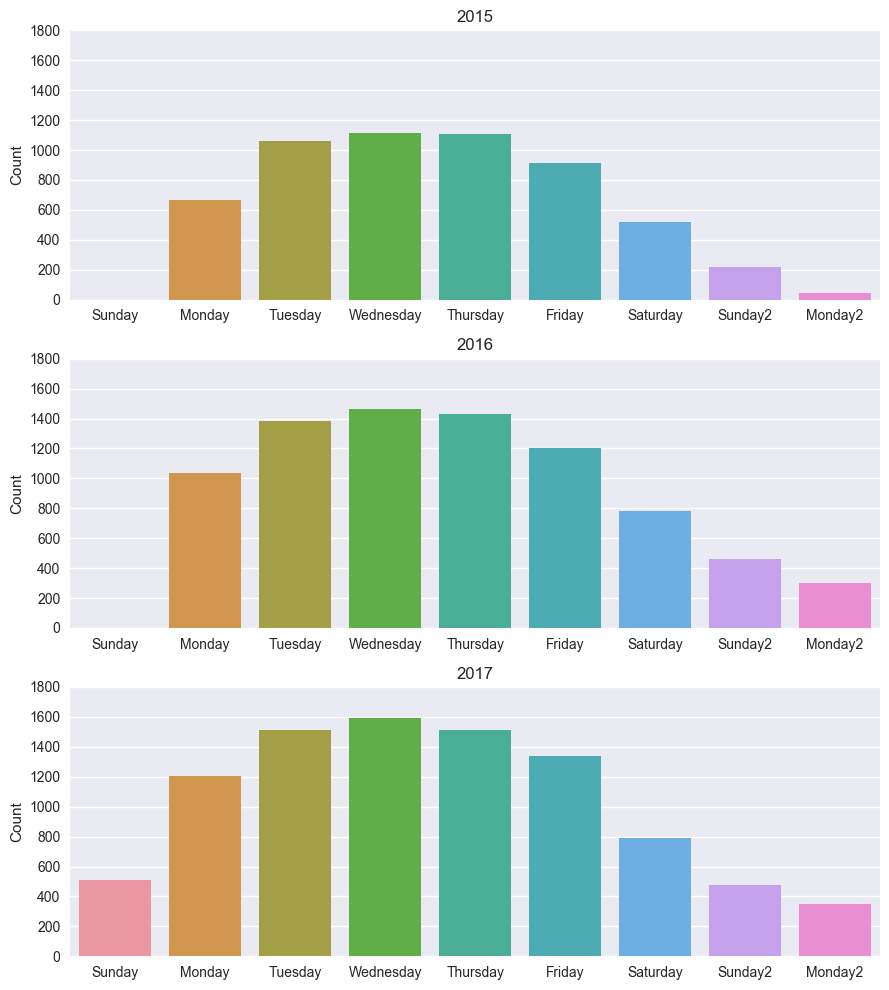

In [44]:
counts_17 = (df_17[df_17.columns.values[:9]] != '-').sum().reset_index()
counts_17.columns = ['day', 'count']

counts_16 = (df_16[df_16.columns.values[:9]] != '-').sum().reset_index()
counts_16.columns = ['day', 'count']

counts_15 = (df_15[df_15.columns.values[:9]] != '-').sum().reset_index()
counts_15.columns = ['day', 'count']

fig = plt.figure(figsize=(9, 10), dpi=100);

axes1 = fig.add_subplot(311); axes2 = fig.add_subplot(312); axes3 = fig.add_subplot(313); 

sns.barplot(x='day', y='count', data=counts_15, ax=axes1)
sns.barplot(x='day', y='count', data=counts_16, ax=axes2)
sns.barplot(x='day', y='count', data=counts_17, ax=axes3)

axes1.set_ylim(0, 1800);axes2.set_ylim(0, 1800);axes3.set_ylim(0, 1800);

axes1.set_xlabel('');axes2.set_xlabel('');axes3.set_xlabel('');

axes1.set_ylabel('Count');axes2.set_ylabel('Count');axes3.set_ylabel('Count');

axes1.set_title('2015');axes2.set_title('2016');axes3.set_title('2017');

fig.tight_layout()

Let's next investigate the event distribution by hour. To do so we'll neeed to construct a function that parses the data and returns a distribution.

In [90]:
def construct_cumulative_times(df):
    # df = dataframe consisting of a list of times
        
    times = [];
    
    for hour in np.arange(0, 24):
        for minutes in np.arange(0, 60, 15):
            time = str(hour)+':'+str(minutes)
            time_date = datetime.datetime.strptime(time, '%H:%M').time()
            times.append(time_date)          
            #times.append(str(hour).zfill(2)+':'+str(minutes).zfill(2))
    
    df_cum = pd.DataFrame(data={'time':times, 'count':[0]*len(times)});

    for row in df.values: 
        if row == '-':
            pass;
        elif row == 'All':
            df_cum['count'].values[:] = df_cum['count'].values[:] + 1;
        else:
            split = row.split("-");

            start_time = datetime.datetime.strptime(split[0], '%H:%M').time()
            end_time   = datetime.datetime.strptime(split[1], '%H:%M').time()
            
            if(end_time == datetime.datetime.strptime('23:59', '%H:%M').time()):
                end_time = datetime.datetime.strptime('23:45', '%H:%M').time();
                            
            index_first  = df_cum['time'][df_cum['time'] == start_time].index.tolist()[0];
            index_second = df_cum['time'][df_cum['time'] == end_time].index.tolist()[0];
        
            df_cum['count'].values[index_first:index_second] = df_cum['count'].values[index_first:index_second] + 1;
    
    return df_cum;

In [91]:
df_17_1 = construct_cumulative_times(df_17['Sunday'])
df_17_2 = construct_cumulative_times(df_17['Monday'])
df_17_3 = construct_cumulative_times(df_17['Tuesday'])
df_17_4 = construct_cumulative_times(df_17['Wednesday'])
df_17_5 = construct_cumulative_times(df_17['Thursday'])
df_17_6 = construct_cumulative_times(df_17['Friday'])
df_17_7 = construct_cumulative_times(df_17['Saturday'])
df_17_8 = construct_cumulative_times(df_17['Sunday2'])
df_17_9 = construct_cumulative_times(df_17['Monday2'])

df_16_1 = construct_cumulative_times(df_16['Sunday'])
df_16_2 = construct_cumulative_times(df_16['Monday'])
df_16_3 = construct_cumulative_times(df_16['Tuesday'])
df_16_4 = construct_cumulative_times(df_16['Wednesday'])
df_16_5 = construct_cumulative_times(df_16['Thursday'])
df_16_6 = construct_cumulative_times(df_16['Friday'])
df_16_7 = construct_cumulative_times(df_16['Saturday'])
df_16_8 = construct_cumulative_times(df_16['Sunday2'])
df_16_9 = construct_cumulative_times(df_16['Monday2'])

df_15_1 = construct_cumulative_times(df_15['Sunday'])
df_15_2 = construct_cumulative_times(df_15['Monday'])
df_15_3 = construct_cumulative_times(df_15['Tuesday'])
df_15_4 = construct_cumulative_times(df_15['Wednesday'])
df_15_5 = construct_cumulative_times(df_15['Thursday'])
df_15_6 = construct_cumulative_times(df_15['Friday'])
df_15_7 = construct_cumulative_times(df_15['Saturday'])
df_15_8 = construct_cumulative_times(df_15['Sunday2'])
df_15_9 = construct_cumulative_times(df_15['Monday2'])

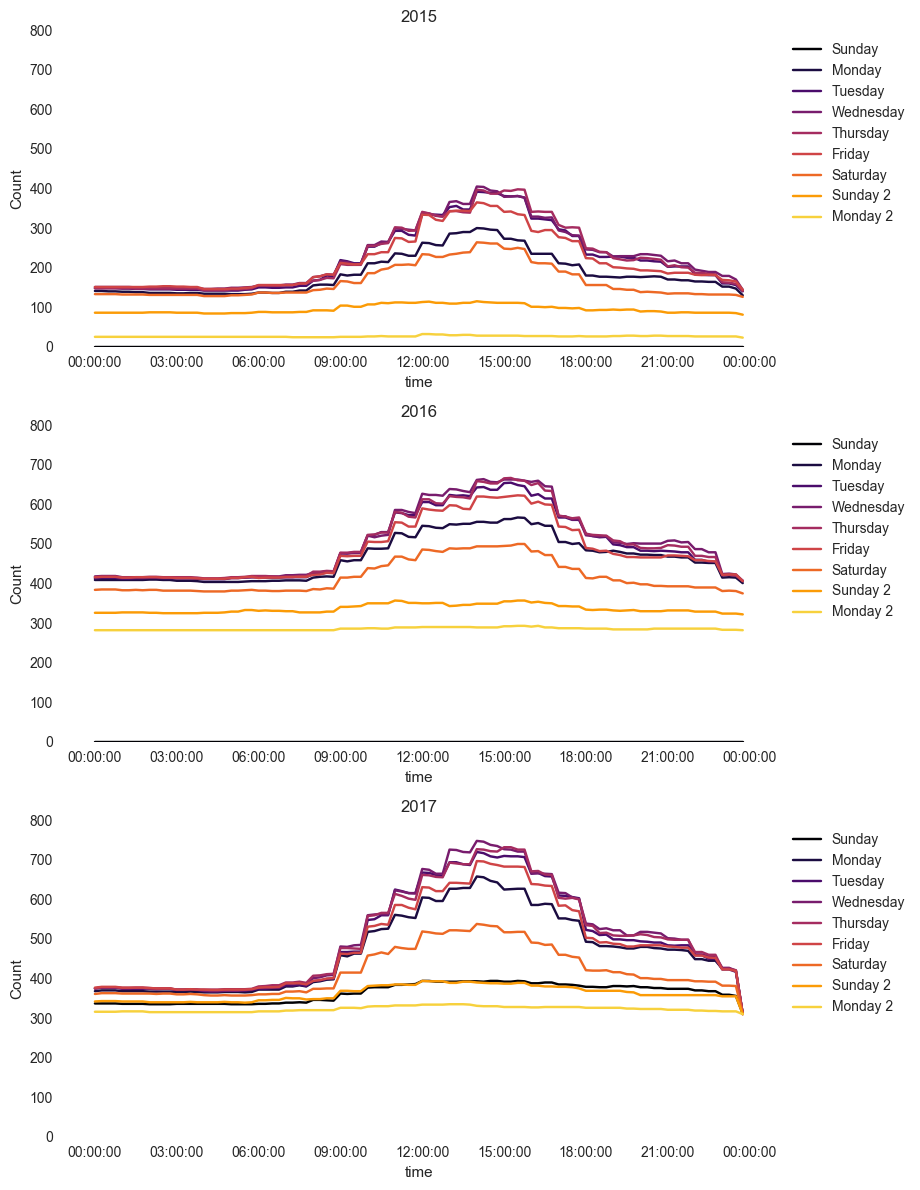

In [100]:
start = 0.0;
stop  = 1.0;
number_of_lines = 10;
cm_subsection = np.linspace(start, stop, number_of_lines) ;
colors = [ cm.inferno(x) for x in cm_subsection ];

fig = plt.figure(figsize=(8, 12), dpi=100);

axes1 = fig.add_subplot(311);axes2 = fig.add_subplot(312);axes3 = fig.add_subplot(313);

axes1.plot(df_15_1['time'], df_15_1['count'], color=colors[0], ls='-');
axes1.plot(df_15_2['time'], df_15_2['count'], color=colors[1], ls='-');
axes1.plot(df_15_3['time'], df_15_3['count'], color=colors[2], ls='-');
axes1.plot(df_15_4['time'], df_15_4['count'], color=colors[3], ls='-');
axes1.plot(df_15_5['time'], df_15_5['count'], color=colors[4], ls='-');
axes1.plot(df_15_6['time'], df_15_6['count'], color=colors[5], ls='-');
axes1.plot(df_15_7['time'], df_15_7['count'], color=colors[6], ls='-');
axes1.plot(df_15_8['time'], df_15_8['count'], color=colors[7], ls='-');
axes1.plot(df_15_9['time'], df_15_9['count'], color=colors[8], ls='-');

axes2.plot(df_16_1['time'], df_16_1['count'], color=colors[0], ls='-');
axes2.plot(df_16_2['time'], df_16_2['count'], color=colors[1], ls='-');
axes2.plot(df_16_3['time'], df_16_3['count'], color=colors[2], ls='-');
axes2.plot(df_16_4['time'], df_16_4['count'], color=colors[3], ls='-');
axes2.plot(df_16_5['time'], df_16_5['count'], color=colors[4], ls='-');
axes2.plot(df_16_6['time'], df_16_6['count'], color=colors[5], ls='-');
axes2.plot(df_16_7['time'], df_16_7['count'], color=colors[6], ls='-');
axes2.plot(df_16_8['time'], df_16_8['count'], color=colors[7], ls='-');
axes2.plot(df_16_9['time'], df_16_9['count'], color=colors[8], ls='-');

axes3.plot(df_17_1['time'], df_17_1['count'], color=colors[0], ls='-');
axes3.plot(df_17_2['time'], df_17_2['count'], color=colors[1], ls='-');
axes3.plot(df_17_3['time'], df_17_3['count'], color=colors[2], ls='-');
axes3.plot(df_17_4['time'], df_17_4['count'], color=colors[3], ls='-');
axes3.plot(df_17_5['time'], df_17_5['count'], color=colors[4], ls='-');
axes3.plot(df_17_6['time'], df_17_6['count'], color=colors[5], ls='-');
axes3.plot(df_17_7['time'], df_17_7['count'], color=colors[6], ls='-');
axes3.plot(df_17_8['time'], df_17_8['count'], color=colors[7], ls='-');
axes3.plot(df_17_9['time'], df_17_9['count'], color=colors[8], ls='-');

axes1.set_ylim(0, 800);axes2.set_ylim(0, 800);axes3.set_ylim(0, 800);

axes1.set_xticks(np.arange(0, 90000, 10800));axes2.set_xticks(np.arange(0, 90000, 10800));axes3.set_xticks(np.arange(0, 90000, 10800));

axes1.set_ylabel('Count');axes2.set_ylabel('Count');axes3.set_ylabel('Count');

axes1.set_title('2015');axes2.set_title('2016');axes3.set_title('2017');

axes1.legend(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday 2', 'Monday 2'], loc='upper right', bbox_to_anchor=(1.2,1));
axes2.legend(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday 2', 'Monday 2'], loc='upper right', bbox_to_anchor=(1.2,1));
axes3.legend(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday 2', 'Monday 2'], loc='upper right', bbox_to_anchor=(1.2,1));

axes1.grid(False);axes2.grid(False);axes3.grid(False);

axes1.set_facecolor('white');axes2.set_facecolor('white');axes3.set_facecolor('white');

#axes1.xaxis_date()
#from matplotlib.dates import DateFormatter
#formatter = DateFormatter('%H:%M')
#axes1.xaxis.set_major_formatter(formatter)  

fig.tight_layout();

Looks like things typically start to get going around 9 AM, and really pick up around noon, reaching a peak at around 2-3 PM. This is more or less consistent between different days, and different years.

# What are the different types of events?

Let's next examine the event distribution by type. "Work" and "Party" events are the most popular by far. "Fire" events are surprisingly rare, but maybe this is just because fire dancing spontaneously occurs at the big sound stages.

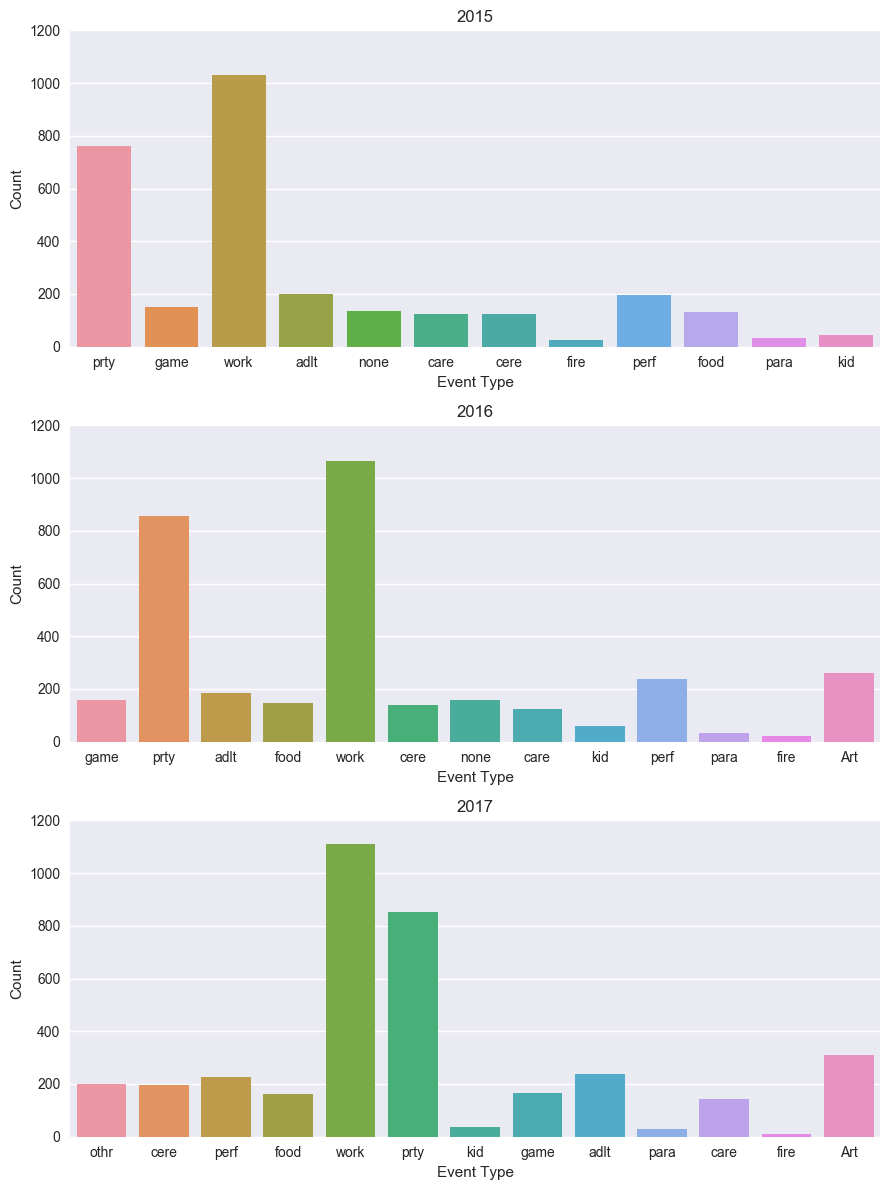

In [105]:
fig = plt.figure(figsize=(9, 12), dpi=100);

axes1 = fig.add_subplot(311);axes2 = fig.add_subplot(312);axes3 = fig.add_subplot(313); 

sns.countplot(df_15.Type, ax=axes1)
sns.countplot(df_16.Type, ax=axes2)
sns.countplot(df_17.Type, ax=axes3)

axes1.set_ylim(0, 1200);
axes2.set_ylim(0, 1200);
axes3.set_ylim(0, 1200);

axes1.set_xlabel('Event Type');
axes2.set_xlabel('Event Type');
axes3.set_xlabel('Event Type');

axes1.set_ylabel('Count');
axes2.set_ylabel('Count');
axes3.set_ylabel('Count');

axes1.set_title('2015');axes2.set_title('2016');axes3.set_title('2017');

fig.tight_layout()

# Who are the most active camps?

Naked Heart killing it with almost 100 events in 2016 and 2017, and more than 200 events in 2015. Center Camp Cafe, Feed the Artists, and Camp Contact consistently score high.

In [128]:
camp_count_17 = df_17['Camp'].value_counts().reset_index();
camp_count_16 = df_16['Camp'].value_counts().reset_index();
camp_count_15 = df_15['Camp'].value_counts().reset_index();

camp_count_17 = camp_count_17[camp_count_17['index'] != '-'];
camp_count_16 = camp_count_16[camp_count_16['index'] != '-'];
camp_count_15 = camp_count_15[camp_count_15['index'] != '-'];

camp_count_filtered_17 = camp_count_17[camp_count_17['Camp'] > 20];
camp_count_filtered_16 = camp_count_16[camp_count_16['Camp'] > 20];
camp_count_filtered_15 = camp_count_15[camp_count_15['Camp'] > 20];

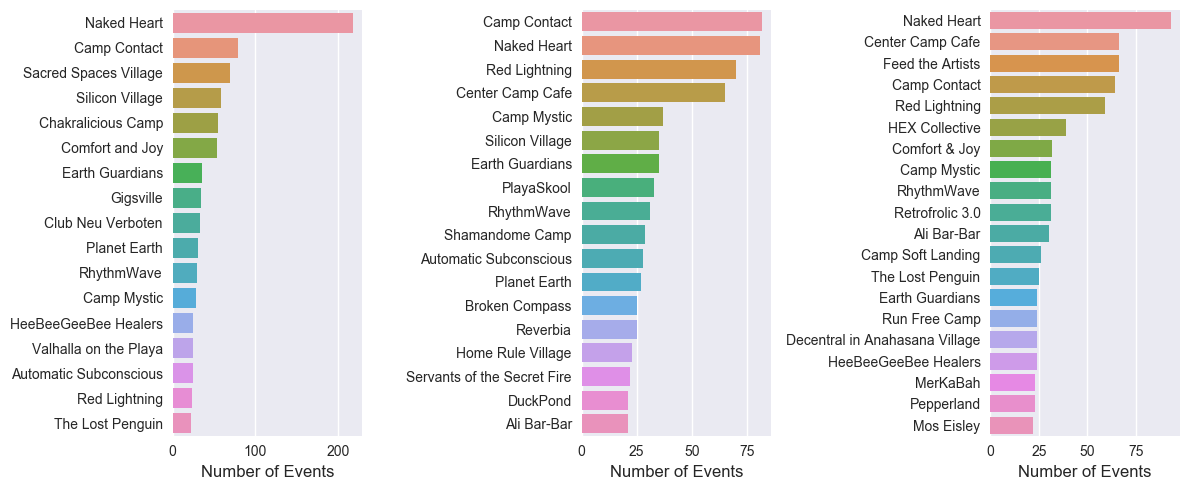

In [132]:
fig = plt.figure(figsize=(12, 5), dpi=100);

axes1 = fig.add_subplot(131); 
axes2 = fig.add_subplot(132); 
axes3 = fig.add_subplot(133); 

sns.barplot(x='Camp', y='index', data=camp_count_filtered_15, ax=axes1);
sns.barplot(x='Camp', y='index', data=camp_count_filtered_16, ax=axes2);
sns.barplot(x='Camp', y='index', data=camp_count_filtered_17, ax=axes3);

#plt.xticks(rotation=90);
#axes1.set_xlim(0, 100)

axes1.set_ylabel('');axes2.set_ylabel('');axes3.set_ylabel('');

axes1.set_xlabel('Number of Events', size=12);axes2.set_xlabel('Number of Events', size=12);axes3.set_xlabel('Number of Events', size=12);

axes1.tick_params(axis='both', which='major', labelsize=10);
axes2.tick_params(axis='both', which='major', labelsize=10);
axes3.tick_params(axis='both', which='major', labelsize=10);

fig.tight_layout();

# Let's take a look at the event descriptions

In [136]:
# Convert Dataframe Column to a joined array of strings
text_17 = ' '.join(list(df_17.Description.values.astype(str))).lower().replace('\n', '').replace('\r', '');

# How many words in total are there?
print('2017 Character Count = ' + str(len(text_17)));
print('2017 Total Word Count = ' + str(len(text_17.split())));
print('2017 Mean Average Word Count = ' + str(len(text_17.split())/len(df_17.Description.values)));

2017 Character Count = 1057949
2017 Total Word Count = 179280
2017 Mean Average Word Count = 48.71739130434783


In [137]:
# Convert Dataframe Column to a joined array of strings
text_16 = ' '.join(list(df_16.Description.values.astype(str))).lower().replace('\n', '').replace('\r', '');

# How many words in total are there?
print('2016 Character Count = ' + str(len(text_16)));
print('2016 Total Word Count = ' + str(len(text_16.split())));
print('2016 Mean Average Word Count = ' + str(len(text_16.split())/len(df_16.Description.values)));

2016 Character Count = 1040636
2016 Total Word Count = 176757
2016 Mean Average Word Count = 51.338077258205054


In [138]:
# Convert Dataframe Column to a joined array of strings
text_15 = ' '.join(list(df_15.Description.values.astype(str))).lower().replace('\n', '').replace('\r', '');

# How many words in total are there?
print('2015 Character Count = ' + str(len(text_15)));
print('2015 Total Word Count = ' + str(len(text_15.split())));
print('2015 Mean Average Word Count = ' + str(len(text_15.split())/len(df_15.Description.values)));

2015 Character Count = 879614
2015 Total Word Count = 149263
2015 Mean Average Word Count = 50.49492557510149


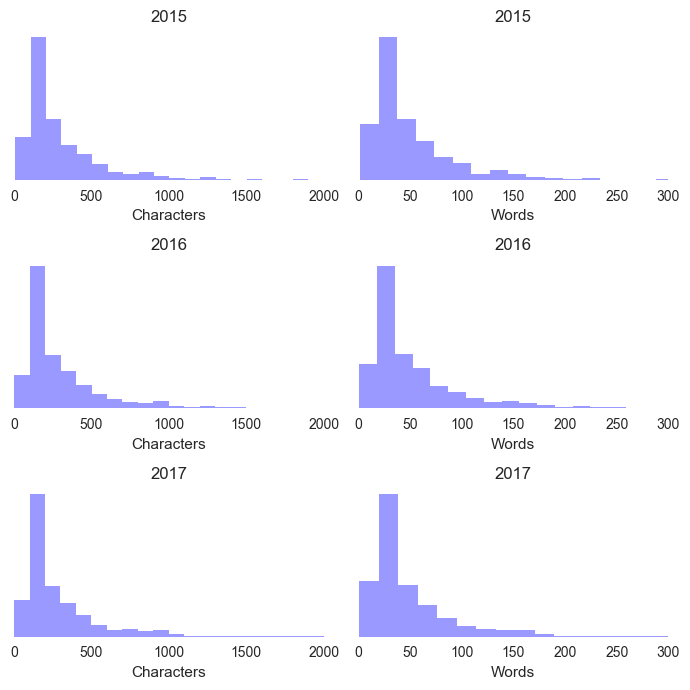

In [145]:
fig = plt.figure(figsize=(7, 7), dpi=100);

axes1 = fig.add_subplot(321);
axes2 = fig.add_subplot(322);
axes3 = fig.add_subplot(323);
axes4 = fig.add_subplot(324);
axes5 = fig.add_subplot(325);
axes6 = fig.add_subplot(326);

sns.distplot([len(event)         for event in list(df_15.Description.values.astype(str))], ax=axes1, kde=False, bins=20, color='blue', axlabel='Characters')
sns.distplot([len(event.split()) for event in list(df_15.Description.values.astype(str))], ax=axes2, kde=False, bins=20, color='blue', axlabel='Words')
sns.distplot([len(event)         for event in list(df_16.Description.values.astype(str))], ax=axes3, kde=False, bins=20, color='blue', axlabel='Characters')
sns.distplot([len(event.split()) for event in list(df_16.Description.values.astype(str))], ax=axes4, kde=False, bins=20, color='blue', axlabel='Words')
sns.distplot([len(event)         for event in list(df_17.Description.values.astype(str))], ax=axes5, kde=False, bins=20, color='blue', axlabel='Characters')
sns.distplot([len(event.split()) for event in list(df_17.Description.values.astype(str))], ax=axes6, kde=False, bins=20, color='blue', axlabel='Words')

axes1.set_xlim(0, 2000);axes2.set_xlim(0, 300);
axes3.set_xlim(0, 2000);axes4.set_xlim(0, 300);
axes5.set_xlim(0, 2000);axes6.set_xlim(0, 300);

axes1.set_yticks([]);axes2.set_yticks([]);
axes3.set_yticks([]);axes4.set_yticks([]);
axes5.set_yticks([]);axes6.set_yticks([]);

axes1.grid(False);axes2.grid(False);
axes3.grid(False);axes4.grid(False);
axes5.grid(False);axes6.grid(False);

axes1.set_facecolor('white');axes2.set_facecolor('white');
axes3.set_facecolor('white');axes4.set_facecolor('white');
axes5.set_facecolor('white');axes6.set_facecolor('white');

axes1.set_title('2015');axes2.set_title('2015');
axes3.set_title('2016');axes4.set_title('2016');
axes5.set_title('2017');axes6.set_title('2017');

fig.tight_layout()

In [154]:
# Convert strings to nltk "token" objects
tokenizer = RegexpTokenizer(r'\w+');

tokens_15 = tokenizer.tokenize(text_15);
tokens_16 = tokenizer.tokenize(text_16);
tokens_17 = tokenizer.tokenize(text_17);

# Convert tokens into an nltk "Text" object
Text_15 = nltk.Text(tokens_15);
Text_16 = nltk.Text(tokens_16);
Text_17 = nltk.Text(tokens_17);

# Filter out stop words
filtered_words_15 = [word for word in Text_15 if word not in stopwords.words('english')];
filtered_words_16 = [word for word in Text_16 if word not in stopwords.words('english')];
filtered_words_17 = [word for word in Text_17 if word not in stopwords.words('english')];

# Filter out short words
filtered_words_15 = [word for word in filtered_words_15 if len(word) > 3];
filtered_words_16 = [word for word in filtered_words_16 if len(word) > 3];
filtered_words_17 = [word for word in filtered_words_17 if len(word) > 3];

fdist_filtered_15 = nltk.FreqDist(filtered_words_15);
fdist_filtered_16 = nltk.FreqDist(filtered_words_16);
fdist_filtered_17 = nltk.FreqDist(filtered_words_17);

Take a look at common collocations

In [155]:
Text_15.collocations()

burning man; black rock; rock city; happy hour; neu verboten; planet
earth; club neu; quack quack; would like; default world; come join;
live music; art car; guided meditation; harmoniously merging; verbal
communication; low club; hip hop; sincere interaction; clothing
optional


In [156]:
Text_16.collocations()

burning man; black rock; rock city; happy hour; dance floor; since
2009; hip hop; planet earth; alternative sound; come join; default
world; real wooden; indoor night; live music; center camp; dance
party; dick shaped; new friends; air conditioned; creepers photography


In [157]:
Text_17.collocations()

burning man; black rock; rock city; radical ritual; happy hour;
default world; dance party; feel free; hip hop; come join; ice cold;
every day; trash fence; creepers photography; come learn; foot tall;
bloody mary; art car; ice cream; photography drugs


For easy visualization, create a word cloud of the most common words in event descriptions.

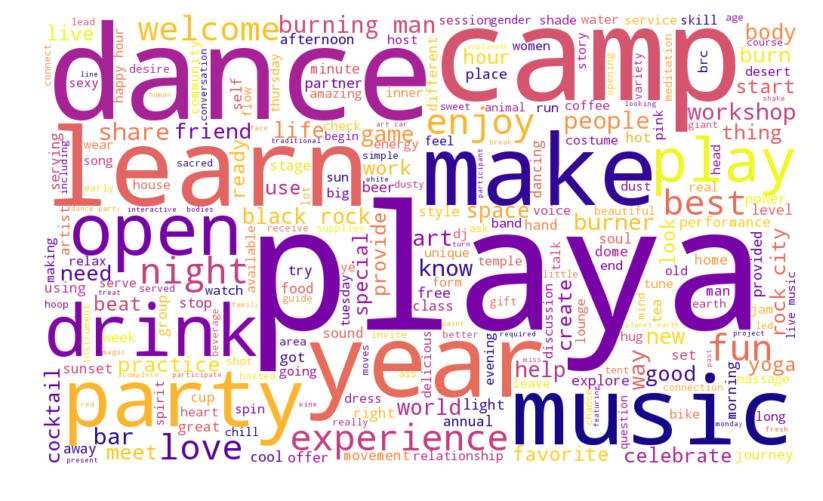

In [158]:
limit = 250
bgcolor = '#FFFFFF'
specific_stopwords = ['come', 'bring', 'join', 'let', 'daily', 'nthe', 'let', 'event', 'want', 'time', 'dj', 'day']
english_stopwords = set(stopwords.words('english')) | STOPWORDS | ENGLISH_STOP_WORDS | set(specific_stopwords)

wordcloud = WordCloud(
    max_words=limit,
    stopwords=english_stopwords,
    background_color=bgcolor,
    width = 1000,
    height = 600,
    colormap = 'plasma'
).generate(text_15)

fig = plt.figure(figsize=(10, 6), dpi=100);

plt.imshow(wordcloud.recolor(random_state=3), interpolation="bilinear")
plt.axis('off')
plt.show()

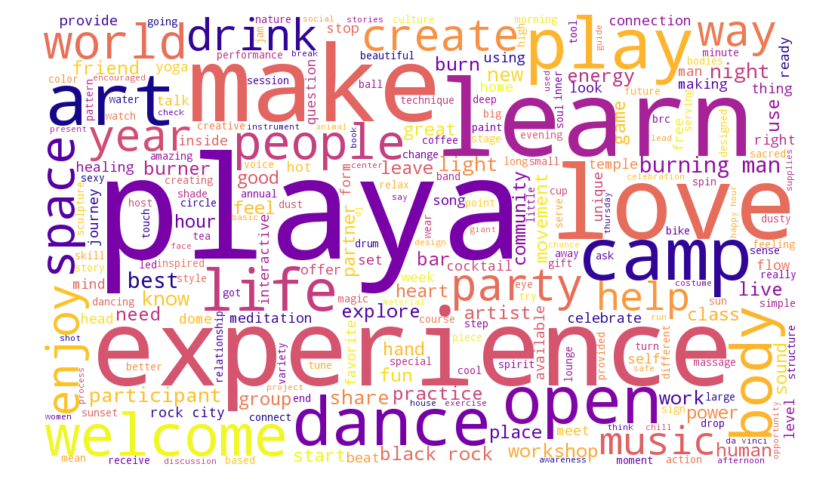

In [159]:
limit = 250
bgcolor = '#FFFFFF'
specific_stopwords = ['come', 'bring', 'join', 'let', 'daily', 'nthe', 'let', 'event', 'want', 'time', 'dj', 'day']
english_stopwords = set(stopwords.words('english')) | STOPWORDS | ENGLISH_STOP_WORDS | set(specific_stopwords)

wordcloud = WordCloud(
    max_words=limit,
    stopwords=english_stopwords,
    background_color=bgcolor,
    width = 1000,
    height = 600,
    colormap = 'plasma'
).generate(text_16)

fig = plt.figure(figsize=(10, 6), dpi=100);

plt.imshow(wordcloud.recolor(random_state=3), interpolation="bilinear")
plt.axis('off')
plt.show()

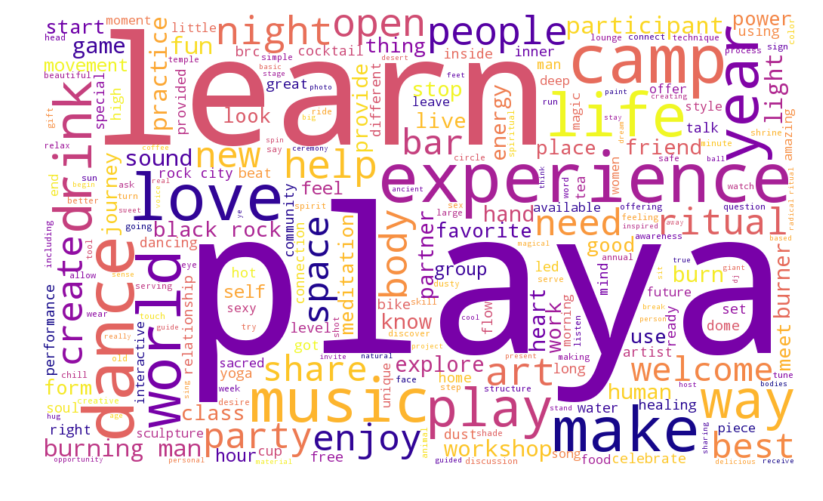

In [160]:
limit = 250
bgcolor = '#FFFFFF'
specific_stopwords = ['come', 'bring', 'join', 'let', 'daily', 'nthe', 'let', 'event', 'want', 'time', 'dj', 'day']
english_stopwords = set(stopwords.words('english')) | STOPWORDS | ENGLISH_STOP_WORDS | set(specific_stopwords)

wordcloud = WordCloud(
    max_words=limit,
    stopwords=english_stopwords,
    background_color=bgcolor,
    width = 1000,
    height = 600,
    colormap = 'plasma'
).generate(text_17)

fig = plt.figure(figsize=(10, 6), dpi=100);

plt.imshow(wordcloud.recolor(random_state=3), interpolation="bilinear")
plt.axis('off')
plt.show()

# How are event locations distributed?

First define a function to parse location information into a Dataframe

In [147]:
def parse_location(df):
    # df = dataframe consisting of values
    # returns a list of polar coordinates corresponding to location
    
    clocks  = [];
    radials = [];
    types   = [];
        
    for index, row in df[['Where', 'Type']].iterrows():
        location   = row['Where'];
        event_type = row['Type']
        
        if pd.isnull(location):
            pass;
        elif '+' not in location:
            pass;
        else:          
            split = location.split('+');
            
            if len(split) != 2:
                pass;
            else:            
                clock  = split[0];
                radial = split[1];
                clocks.append(clock);
                radials.append(radial);
                types.append(event_type);
            
    df_locations = pd.DataFrame(data={'clocks':clocks, 'radials':radials, 'types':types});
    
    return df_locations;

In [153]:
df_locations_17 = parse_location(df_17);
df_locations_16 = parse_location(df_16);
df_locations_15 = parse_location(df_15);

print(df_locations_17['radials'].unique())
print(df_locations_16['radials'].unique())
print(df_locations_15['radials'].unique())

['Awe' 'Eulogy' 'Genuflect' 'Dance' 'Ceremony' 'Portal' 'Inspirit'
 'Rods Road' 'Plaza' 'Fire' 'Breath' 'Center Camp Plaza' 'Esplanade'
 'Hallowed' 'Kundalini' 'Juju' 'Deep Plaza' 'Lustrate' ' Cafe']
['Esplanade' 'Botticelli' 'Donatello' 'Lorenzo' 'Cosimo' 'Justice'
 'Effigare' 'Arno' 'Florin' 'Deep Plaza' 'Guild' 'High Renaissance'
 'Rods Road' 'Italic' 'Inner Circle' 'Plaza' 'Portal' '8:45' 'Knowledge'
 'Landing Strip' ' 8:45']
[' Ballyhoo']


In [152]:
df_locations_17 = parse_location(df_17);
df_locations_16 = parse_location(df_16);
df_locations_15 = parse_location(df_15);

print(df_locations_17['radials'].unique())
print(df_locations_16['radials'].unique())
print(df_locations_15['radials'].unique())

print('\n Drop radials with unclear names \n');

df_locations_17 = df_locations_17[df_locations_17['radials'] != 'Deep Plaza']
df_locations_16 = df_locations_16[df_locations_16['radials'] != 'Deep Plaza']
df_locations_15 = df_locations_15[df_locations_15['radials'] != 'Deep Plaza']

df_locations_17 = df_locations_17[df_locations_17['radials'] != ' Cafe']
df_locations_16 = df_locations_16[df_locations_16['radials'] != ' Cafe']
df_locations_15 = df_locations_15[df_locations_15['radials'] != ' Cafe']

#df_locations = df_locations[df_locations['radials'] != 'Plaza']
#df_locations = df_locations[df_locations['radials'] != 'Portal']
#df_locations = df_locations[df_locations['radials'] != 'Rods Road']
#df_locations = df_locations[df_locations['radials'] != 'Center Camp Plaza']

print(df_locations_17['radials'].unique())
print(df_locations_16['radials'].unique())
print(df_locations_15['radials'].unique())

print('\n Parse Radials \n')

radial_map = dict();

radial_map['Esplanade'] = 0.9;

radial_map['Awe']       = 1.1;
radial_map['Breath']    = 1.2;
radial_map['Ceremony']  = 1.3;
radial_map['Dance']     = 1.4;
radial_map['Eulogy']    = 1.5;
radial_map['Fire']      = 1.6;
radial_map['Genuflect'] = 1.7;
radial_map['Hallowed']  = 1.8;
radial_map['Inspirit']  = 1.9;
radial_map['Juju']      = 2.0;
radial_map['Kundalini'] = 2.1;
radial_map['Lustrate']  = 2.2;

radial_map['Center Camp Plaza'] = 1.2;
radial_map['Plaza']     = 1.2;
radial_map['Portal']    = 1.2;
radial_map['Rods Road'] = 1.2;

df_locations_17['radials'] = df_locations_17['radials'].map(radial_map)
df_locations_16['radials'] = df_locations_16['radials'].map(radial_map)
df_locations_15['radials'] = df_locations_15['radials'].map(radial_map)

#print(df_locations_17['radials'].unique())
#print(df_locations_16['radials'].unique())
#print(df_locations_15['radials'].unique())

['Awe' 'Eulogy' 'Genuflect' 'Dance' 'Ceremony' 'Portal' 'Inspirit'
 'Rods Road' 'Plaza' 'Fire' 'Breath' 'Center Camp Plaza' 'Esplanade'
 'Hallowed' 'Kundalini' 'Juju' 'Deep Plaza' 'Lustrate' ' Cafe']
['Esplanade' 'Botticelli' 'Donatello' 'Lorenzo' 'Cosimo' 'Justice'
 'Effigare' 'Arno' 'Florin' 'Deep Plaza' 'Guild' 'High Renaissance'
 'Rods Road' 'Italic' 'Inner Circle' 'Plaza' 'Portal' '8:45' 'Knowledge'
 'Landing Strip' ' 8:45']
[' Ballyhoo']

 Drop radials with unclear names 

['Awe' 'Eulogy' 'Genuflect' 'Dance' 'Ceremony' 'Portal' 'Inspirit'
 'Rods Road' 'Plaza' 'Fire' 'Breath' 'Center Camp Plaza' 'Esplanade'
 'Hallowed' 'Kundalini' 'Juju' 'Lustrate']
['Esplanade' 'Botticelli' 'Donatello' 'Lorenzo' 'Cosimo' 'Justice'
 'Effigare' 'Arno' 'Florin' 'Guild' 'High Renaissance' 'Rods Road' 'Italic'
 'Inner Circle' 'Plaza' 'Portal' '8:45' 'Knowledge' 'Landing Strip' ' 8:45']
[' Ballyhoo']

 Parse Radials 



Convert "hours" to an angle for polar plots

In [52]:
def clock_to_angle(time):
    hour, minutes = time.split(':');
    
    return (2*pi*int(hour)/12) + ((2*pi/12)*int(minutes)/60);

df_locations['clocks'] = df_locations['clocks'].map(clock_to_angle)

print(df_locations['radials'].unique())

df_locations = df_locations.dropna(axis=0)

#plt.figure(figsize=(10, 4));
#sns.distplot(df_locations['clocks'].values)
#plt.xticks(rotation=0);

[ 1.1  1.5  1.7  1.4  1.3  1.2  1.9  1.6  0.9  1.8  2.1  2.   2.2]


Color coding by event type

In [53]:
color_map = dict();

color_map['othr'] = 'grey';
color_map['cere'] = 'purple';
color_map['food'] = 'green';
color_map['work'] = 'brown';
color_map['prty'] = 'blue';
color_map['perf'] = 'gold';
color_map['kid']  = 'cyan';
color_map['game'] = 'pink';
color_map['adlt'] = 'black';
color_map['care'] = 'yellow';
color_map['para'] = 'orange';
color_map['fire'] = 'red';

colors = df_locations_17['types'].map(color_map)

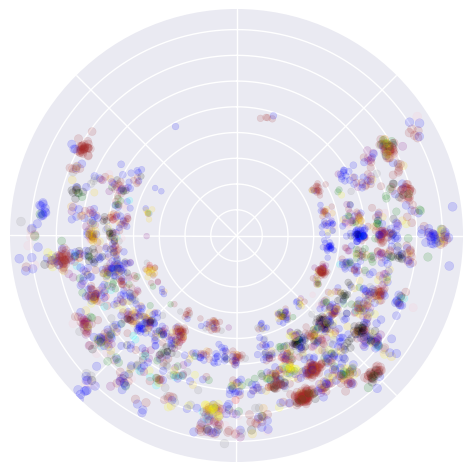

In [54]:
clockJitter   = 0.03*np.random.randn(len(df_locations_17['clocks'].values));
radial_jitter = 0.03*np.random.randn(len(df_locations_17['radials'].values));

fig = plt.figure(figsize=(6, 6), dpi=100);
ax = fig.add_subplot(111, polar=True); 

c = scatter(df_locations_17['clocks'].values  + clockJitter, 
            df_locations_17['radials'].values + radial_jitter, 
            s=20*df_locations_17['radials'].values, c=colors)

c.set_alpha(0.15)

ax.set_rmax(2.2)

ax.set_theta_zero_location('N')

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
#ax.legend()

show()

There's clearly a lot going on, but it's hard to tell from this plot. Let's take a look at a KDE plot to see if that provides some clearer insight. 

[]

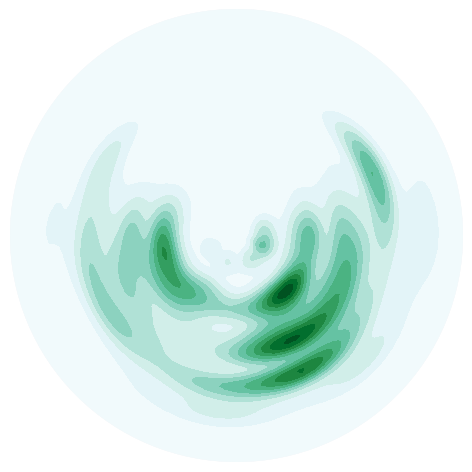

In [11]:
fig = plt.figure(figsize=(6, 6), dpi=100);
ax = fig.add_subplot(111, polar=True); 

sns.kdeplot(df_locations_17[['clocks', 'radials']], shade=True, ax=ax, gridsize=100, cbar=True);

ax.set_rmax(2.2);
ax.set_theta_zero_location('N');
ax.xaxis.set_ticklabels([]);
ax.yaxis.set_ticklabels([]);

Yup. Looks like most events are clustered around the 4-5 o'clock, with another big cluster around 8'o clock. Let's take a closer look at event distribution by type

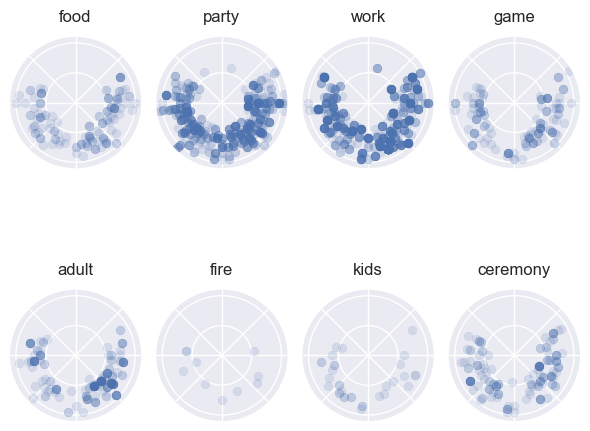

In [22]:
fig = plt.figure(figsize=(6, 6), dpi=100);

ax1 = fig.add_subplot(241, polar=True); 
ax2 = fig.add_subplot(242, polar=True); 
ax3 = fig.add_subplot(243, polar=True); 
ax4 = fig.add_subplot(244, polar=True); 
ax5 = fig.add_subplot(245, polar=True); 
ax6 = fig.add_subplot(246, polar=True); 
ax7 = fig.add_subplot(247, polar=True); 
ax8 = fig.add_subplot(248, polar=True); 

c1 = ax1.scatter(df_locations[df_locations_17['types'] == 'food']['clocks'].values, 
                 df_locations[df_locations_17['types'] == 'food']['radials'].values, 
                 s=40)

c2 = ax2.scatter(df_locations[df_locations_17['types'] == 'prty']['clocks'].values, 
                 df_locations[df_locations_17['types'] == 'prty']['radials'].values, 
                 s=40)

c3 = ax3.scatter(df_locations[df_locations_17['types'] == 'work']['clocks'].values, 
                 df_locations[df_locations_17['types'] == 'work']['radials'].values, 
                 s=40)

c4 = ax4.scatter(df_locations[df_locations_17['types'] == 'game']['clocks'].values, 
                 df_locations[df_locations_17['types'] == 'game']['radials'].values, 
                 s=40)

c5 = ax5.scatter(df_locations[df_locations_17['types'] == 'adlt']['clocks'].values, 
                 df_locations[df_locations_17['types'] == 'adlt']['radials'].values, 
                 s=40)

c6 = ax6.scatter(df_locations[df_locations_17['types'] == 'fire']['clocks'].values, 
                 df_locations[df_locations_17['types'] == 'fire']['radials'].values, 
                 s=40)

c7 = ax7.scatter(df_locations[df_locations_17['types'] == 'kid']['clocks'].values, 
                 df_locations[df_locations_17['types'] == 'kid']['radials'].values, 
                 s=40)

c8 = ax8.scatter(df_locations[df_locations_17['types'] == 'cere']['clocks'].values, 
                 df_locations[df_locations_17['types'] == 'cere']['radials'].values, 
                 s=40)

c1.set_alpha(0.15);c2.set_alpha(0.15);c3.set_alpha(0.15);c4.set_alpha(0.15);
c5.set_alpha(0.15);c6.set_alpha(0.15);c7.set_alpha(0.15);c8.set_alpha(0.15);

ax1.set_rmax(2.2);ax2.set_rmax(2.2);ax3.set_rmax(2.2);ax4.set_rmax(2.2);
ax5.set_rmax(2.2);ax6.set_rmax(2.2);ax7.set_rmax(2.2);ax8.set_rmax(2.2);

ax1.set_theta_zero_location('N');ax2.set_theta_zero_location('N');
ax3.set_theta_zero_location('N');ax4.set_theta_zero_location('N');
ax5.set_theta_zero_location('N');ax6.set_theta_zero_location('N');
ax7.set_theta_zero_location('N');ax8.set_theta_zero_location('N');

ax1.xaxis.set_ticklabels([]);ax2.xaxis.set_ticklabels([]);ax3.xaxis.set_ticklabels([]);ax4.xaxis.set_ticklabels([]);
ax5.xaxis.set_ticklabels([]);ax6.xaxis.set_ticklabels([]);ax7.xaxis.set_ticklabels([]);ax8.xaxis.set_ticklabels([]);

ax1.yaxis.set_ticklabels([]);ax2.yaxis.set_ticklabels([]);ax3.yaxis.set_ticklabels([]);ax4.yaxis.set_ticklabels([]);
ax5.yaxis.set_ticklabels([]);ax6.yaxis.set_ticklabels([]);ax7.yaxis.set_ticklabels([]);ax8.yaxis.set_ticklabels([]);

ax1.set_title('food');
ax2.set_title('party');
ax3.set_title('work');
ax4.set_title('game');
ax5.set_title('adult');
ax6.set_title('fire');
ax7.set_title('kids');
ax8.set_title('ceremony');

fig.tight_layout();

show()

# Sentiment Analysis

Let's run a quick sentiment analysis with NLTK's VADER algorithm. 

Looks like the overall sentiment score is close to neutral and slightly positive.

If we look at the distribution of scores by event, we see that the descriptions are definitely not negative, only a little positive, and with a large degree of neutrality. The compound score is positive-leaning, but with a large peak near zero.

...although perhaps we shouldn't put too much stock on this particular sentiment analysis. Burners enjoy wordplay, snark, and have their own slang, which may not be adequatly captured.

In [161]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA;

sia = SIA();

polarity_scores_15 = [sia.polarity_scores(str(event)) for event in df_15.Description.values];
polarity_scores_16 = [sia.polarity_scores(str(event)) for event in df_16.Description.values];
polarity_scores_17 = [sia.polarity_scores(str(event)) for event in df_17.Description.values];

print('Overall 2015 Polarity Scores: ' + str(sia.polarity_scores(text_15)));
print('Overall 2016 Polarity Scores: ' + str(sia.polarity_scores(text_16)));
print('Overall 2017 Polarity Scores: ' + str(sia.polarity_scores(text_17)));

C:\ProgramData\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Overall 2015 Polarity Scores: {'neg': 0.046, 'neu': 0.748, 'pos': 0.206, 'compound': 1.0}
Overall 2016 Polarity Scores: {'neg': 0.044, 'neu': 0.754, 'pos': 0.202, 'compound': 1.0}
Overall 2017 Polarity Scores: {'neg': 0.049, 'neu': 0.752, 'pos': 0.199, 'compound': 1.0}


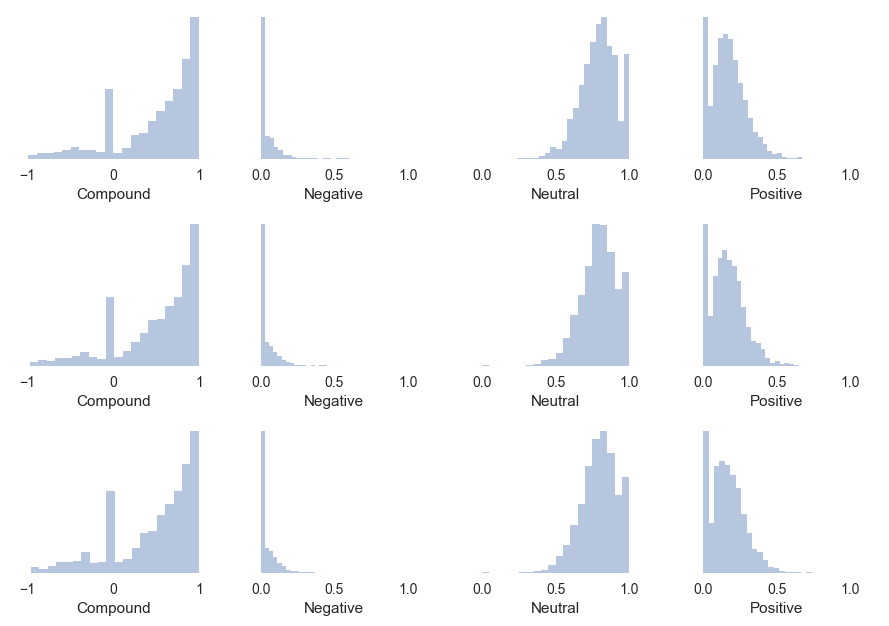

In [165]:
fig = plt.figure(figsize=(9, 8), dpi=100);

axes1 = fig.add_subplot(4,4,1); axes2 = fig.add_subplot(4,4,2);   axes3 = fig.add_subplot(4,4,3);   axes4 = fig.add_subplot(4,4,4); 
axes5 = fig.add_subplot(4,4,5); axes6 = fig.add_subplot(4,4,6);   axes7 = fig.add_subplot(4,4,7);   axes8 = fig.add_subplot(4,4,8); 
axes9 = fig.add_subplot(4,4,9); axes10 = fig.add_subplot(4,4,10); axes11 = fig.add_subplot(4,4,11); axes12 = fig.add_subplot(4,4,12); 

sns.distplot([event['compound'] for event in polarity_scores_15], ax=axes1, kde=False, bins=20, axlabel='Compound')
sns.distplot([event['neg']      for event in polarity_scores_15], ax=axes2, kde=False, bins=20, axlabel='Negative')
sns.distplot([event['neu']      for event in polarity_scores_15], ax=axes3, kde=False, bins=20, axlabel='Neutral')
sns.distplot([event['pos']      for event in polarity_scores_15], ax=axes4, kde=False, bins=20, axlabel='Positive')

sns.distplot([event['compound'] for event in polarity_scores_16], ax=axes5, kde=False, bins=20, axlabel='Compound')
sns.distplot([event['neg']      for event in polarity_scores_16], ax=axes6, kde=False, bins=20, axlabel='Negative')
sns.distplot([event['neu']      for event in polarity_scores_16], ax=axes7, kde=False, bins=20, axlabel='Neutral')
sns.distplot([event['pos']      for event in polarity_scores_16], ax=axes8, kde=False, bins=20, axlabel='Positive')

sns.distplot([event['compound'] for event in polarity_scores_17], ax=axes9,  kde=False, bins=20, axlabel='Compound')
sns.distplot([event['neg']      for event in polarity_scores_17], ax=axes10, kde=False, bins=20, axlabel='Negative')
sns.distplot([event['neu']      for event in polarity_scores_17], ax=axes11, kde=False, bins=20, axlabel='Neutral')
sns.distplot([event['pos']      for event in polarity_scores_17], ax=axes12, kde=False, bins=20, axlabel='Positive')

axes1.set_xlim(-1.2, 1.2);
axes2.set_xlim(-0.2, 1.2);
axes3.set_xlim(-0.2, 1.2);
axes4.set_xlim(-0.2, 1.2);
axes5.set_xlim(-1.2, 1.2);
axes6.set_xlim(-0.2, 1.2);
axes7.set_xlim(-0.2, 1.2);
axes8.set_xlim(-0.2, 1.2);
axes9.set_xlim(-1.2, 1.2);
axes10.set_xlim(-0.2, 1.2);
axes11.set_xlim(-0.2, 1.2);
axes12.set_xlim(-0.2, 1.2);

axes1.set_yticks([]);axes2.set_yticks([]);axes3.set_yticks([]);axes4.set_yticks([]);
axes5.set_yticks([]);axes6.set_yticks([]);axes7.set_yticks([]);axes8.set_yticks([]);
axes9.set_yticks([]);axes10.set_yticks([]);axes11.set_yticks([]);axes12.set_yticks([]);

axes1.grid(False);axes2.grid(False);axes3.grid(False);axes4.grid(False);
axes5.grid(False);axes6.grid(False);axes7.grid(False);axes8.grid(False);
axes9.grid(False);axes10.grid(False);axes11.grid(False);axes12.grid(False);

axes1.set_facecolor('white');axes2.set_facecolor('white');axes3.set_facecolor('white');axes4.set_facecolor('white');
axes5.set_facecolor('white');axes6.set_facecolor('white');axes7.set_facecolor('white');axes8.set_facecolor('white');
axes9.set_facecolor('white');axes10.set_facecolor('white');axes11.set_facecolor('white');axes12.set_facecolor('white');

fig.tight_layout()

# Let's try to build an event classifier

A similar application is the Facebook Event Classifier, which attempts to categorize events (e.g. parties, concerts, games).

In [5]:
events_15 = df_15[['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday2', 'Monday2', 
                   'Description', 'Type', 'Camp', 'Title']];
events_16 = df_16[['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday2', 'Monday2', 
                   'Description', 'Type', 'Camp', 'Title']];
events_17 = df_17[['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday2', 'Monday2', 
                   'Description', 'Type', 'Camp', 'Title']];

days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday2', 'Monday2'];

events_15[days] = ((events_15[days] == '-') == False).astype(int);
events_16[days] = ((events_16[days] == '-') == False).astype(int);
events_17[days] = ((events_17[days] == '-') == False).astype(int);

events_15 = events_15.dropna(axis=0)
events_16 = events_16.dropna(axis=0)
events_17 = events_17.dropna(axis=0)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2440: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [6]:
events_15.tail()

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday2,Monday2,Description,Type,Camp,Title
2951,0,0,0,1,0,0,0,0,0,Are you camping and attending Burning Man on y...,prty,Alternative Energy Zone,Solo Burners Meetup
2952,0,0,0,1,0,0,0,0,0,This Yoga Class has its focus in the Heart Cha...,work,Naked Heart,Naked Heart Care Yoga
2953,0,0,0,1,0,0,0,0,0,"While everyone else is enjoying white parties,...",prty,Stag Camp 9,Goth Night 2.0
2954,0,0,0,1,0,0,0,0,0,Stag Camp's own Replacement wants to host the ...,prty,Stag Camp 9,Hateful Happy Hour!
2955,0,0,0,0,0,1,0,0,0,"Cultivate your natural state of health, vitali...",work,Naked Heart,Harness the Vital Source Qigong


In [7]:
events_16.tail()

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday2,Monday2,Description,Type,Camp,Title
3438,0,1,1,1,1,1,1,1,1,Flocons is a dynamic and evolving series of la...,Art,-,Flocons
3439,0,1,1,1,1,1,1,1,1,"So the Art project ""Pork Chop Nebula"" is a con...",Art,-,The Pork Chop Nebula 2.0
3440,0,1,1,1,1,1,1,1,1,MirrorrorriM is a kaleidoscope the size of a s...,Art,-,MirrorrorriM
3441,0,1,1,1,1,1,1,1,1,A crystal like cluster of Lighthouses ranging ...,Art,-,The Black Rock Lighthouse Service
3442,0,1,1,1,1,1,1,1,1,In resonance with the Leonardo’s Renaissance -...,Art,-,Helios


In [8]:
events_17.tail()

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday2,Monday2,Description,Type,Camp,Title
3675,1,1,1,1,1,1,1,1,1,Shrine de Vine is a nature and architecturally...,Art,-,Shrine de Vine
3676,1,1,1,1,1,1,1,1,1,Large burningmanesque bear. Contains the poem ...,Art,-,The Bear
3677,1,1,1,1,1,1,1,1,1,a grounded whimsical ice cream cone made of mi...,Art,-,WeScream
3678,1,1,1,1,1,1,1,1,1,Rhythmic Ritual Of Love incorporates the most ...,Art,-,Rhythmic Ritual Of Love
3679,1,1,1,1,1,1,1,1,1,"Solaris stands as a large, colorfully painted ...",Art,-,Solaris


In [9]:
events_15['Type'] = events_15['Type'].replace(to_replace='none', value='othr');
events_16['Type'] = events_16['Type'].replace(to_replace='none', value='othr');

In [10]:
print(np.unique(events_15['Type'].values))
print(np.unique(events_16['Type'].values))
print(np.unique(events_17['Type'].values))

['adlt' 'care' 'cere' 'fire' 'food' 'game' 'kid' 'othr' 'para' 'perf'
 'prty' 'work']
['Art' 'adlt' 'care' 'cere' 'fire' 'food' 'game' 'kid' 'othr' 'para' 'perf'
 'prty' 'work']
['Art' 'adlt' 'care' 'cere' 'fire' 'food' 'game' 'kid' 'othr' 'para' 'perf'
 'prty' 'work']


In [11]:
events = pd.concat([events_15, events_16, events_17])

Run the CountVectorizer on the event descriptions and event titles

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(stop_words='english', min_df=15)

X = count_vect.fit_transform(events['Description'].values);
X_titles = count_vect.fit_transform(events['Title'].values);

iX_desc  = X.shape[1]
iX_title = X_titles.shape[1]

print(X.shape)
print(X_titles.shape)

(10078, 3027)
(10078, 389)


One-Hot-Encode the camp names

In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

enc = OneHotEncoder();
le  = LabelEncoder();

camps = events['Camp'].values

events['Camp'] = le.fit_transform(camps)

camps = enc.fit_transform(events[['Camp']])

camps.toarray().shape

(10078, 1041)

Merge the data on the event description, event title, event day, and camp name.

In [14]:
print(shape(X));
print(shape(X_titles));
print(shape(events[days].values));
print(shape(camps.toarray()));

desc_length = shape(X)[1]

print(desc_length)

(10078, 3027)
(10078, 389)
(10078, 9)
(10078, 1041)
3027


In [15]:
from scipy import sparse

X = sparse.csr_matrix(hstack((X.toarray(), X_titles.toarray(), events[days].values, camps.toarray())))
#X = sparse.csr_matrix(hstack((X.toarray(), X_titles.toarray(), events[days].values)))

print(shape(X))

(10078, 4466)


We could also apply a TFIDF (term frequency - inverse document frequency) transformation on the text, but it turns out this strongly degrades performance. Perhaps we just don't have enough data points for TFIDF to be useful.

In [16]:
#from sklearn.feature_extraction.text import TfidfTransformer

#tf_transformer = TfidfTransformer(use_idf=False).fit(X)

#X_tf = tf_transformer.transform(X)

One-hot-encode the event types

In [17]:
le = LabelEncoder()

le.fit(events['Type'].values)

labels = le.classes_;

print(le.classes_)

y = le.transform(events['Type'].values) 

['Art' 'adlt' 'care' 'cere' 'fire' 'food' 'game' 'kid' 'othr' 'para' 'perf'
 'prty' 'work']


Let's do a train-test-split. We have a relatively small amount of data, so we're going to do a relatively large split of 50%.

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5039, 4466)
(5039, 4466)
(5039,)
(5039,)


Now that we've prepared the data, let's try a simple Multinomial Naive Bayes classifier.

In [19]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train, y_train)

pred = clf.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error;

#print("Confusion Matrix")
#print(confusion_matrix(y_test, pred));
#print("\n")

print("Classification Report")
print(classification_report(y_test, pred, target_names=labels));
print("\n")

Classification Report
             precision    recall  f1-score   support

        Art       0.73      0.97      0.83       285
       adlt       0.68      0.50      0.57       311
       care       0.53      0.44      0.48       196
       cere       0.50      0.33      0.39       230
       fire       0.00      0.00      0.00        28
       food       0.57      0.55      0.56       222
       game       0.65      0.59      0.62       236
        kid       0.46      0.09      0.14        70
       othr       0.25      0.22      0.24       246
       para       0.87      0.28      0.42        47
       perf       0.63      0.55      0.58       331
       prty       0.67      0.82      0.74      1235
       work       0.80      0.83      0.82      1602

avg / total       0.67      0.69      0.67      5039





C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
import xgboost as xgb;

clf = xgb.XGBClassifier().fit(X_train.toarray(), y_train)

pred = clf.predict(X_test.toarray())

#print("Confusion Matrix")
#print(confusion_matrix(y_test, pred));
#print("\n")

print("Classification Report")
print(classification_report(y_test, pred, target_names=labels));
print("\n")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Classification Report
             precision    recall  f1-score   support

        Art       0.96      1.00      0.98       285
       adlt       0.88      0.41      0.56       311
       care       0.66      0.22      0.33       196
       cere       0.51      0.20      0.29       230
       fire       0.50      0.04      0.07        28
       food       0.73      0.33      0.45       222
       game       0.70      0.37      0.49       236
        kid       0.47      0.11      0.18        70
       othr       0.46      0.05      0.09       246
       para       0.89      0.51      0.65        47
       perf       0.79      0.40      0.54       331
       prty       0.64      0.74      0.69      1235
       work       0.59      0.93      0.72      1602

avg / total       0.66      0.64      0.60      5039





66% f1-score. Not bad. Random guessing for an evenly distributed data set (which this is not) would give an accuracy of 7.7%, so at first glance we seem to be doing much better than random guessing. 

The train/test data is relatively sparse. Let's augment the training data by randomly dropping words out of the descriptions, thereby effectively regularizing the classifier.

In [21]:
def augmentData(X, y, columns, drop=0.1, n=2):
    # Reduce overfitting by randomly dropping a percentage of the description text
    
    height = X.shape[0]
    
    X = sparse.csr_matrix(np.tile(X.toarray(),(n,1)))
    y = np.tile(y,(n))
    
    #to_augment = X[height:, :columns]
    
    for row in range(X.shape[0]):
        true_indices = np.nonzero(X[row,:].toarray())[1];
        to_drop = [i for i in true_indices*np.random.choice([0, 1], len(true_indices), p=[1-drop, drop]) if i];
        
        for i in to_drop:
            X[row,i] = 0;
    
    return X, y;

In [22]:
X_train2, y_train2 = augmentData(X_train, y_train, desc_length, drop=0.1, n=10)

print(shape(X_train2))
print(shape(y_train2))

(50390, 4466)
(50390,)


In [23]:
clf = MultinomialNB().fit(X_train2, y_train2)

pred = clf.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error;

#print("Confusion Matrix")
#print(confusion_matrix(y_test, pred));
#print("\n")

print("Classification Report")
print(classification_report(y_test, pred, target_names=labels));
print("\n")

Classification Report
             precision    recall  f1-score   support

        Art       0.80      0.92      0.86       285
       adlt       0.69      0.51      0.58       311
       care       0.52      0.45      0.48       196
       cere       0.47      0.37      0.42       230
       fire       0.28      0.29      0.28        28
       food       0.52      0.60      0.56       222
       game       0.59      0.61      0.60       236
        kid       0.19      0.19      0.19        70
       othr       0.27      0.26      0.26       246
       para       0.46      0.53      0.50        47
       perf       0.61      0.56      0.58       331
       prty       0.71      0.76      0.73      1235
       work       0.82      0.82      0.82      1602

avg / total       0.67      0.68      0.68      5039





Now we're getting an average f1-score of 68%, without throwing the "ill-defined" warning. A slight improvement. 

Examining the f1-score per category, we see that the lowest scores tend to belong to those categories with the smallest amount of examples (fire, kid). The most reliably predicted categories are Art, Party, and Work.

In [24]:
clf = xgb.XGBClassifier().fit(X_train2.toarray(), y_train2)

pred = clf.predict(X_test.toarray())

#print("Confusion Matrix")
#print(confusion_matrix(y_test, pred));
#print("\n")

print("Classification Report")
print(classification_report(y_test, pred, target_names=labels));
print("\n")

Classification Report
             precision    recall  f1-score   support

        Art       0.85      1.00      0.92       285
       adlt       0.84      0.41      0.55       311
       care       0.71      0.24      0.36       196
       cere       0.59      0.23      0.34       230
       fire       0.33      0.07      0.12        28
       food       0.73      0.37      0.49       222
       game       0.70      0.38      0.49       236
        kid       0.62      0.11      0.19        70
       othr       0.52      0.07      0.12       246
       para       0.84      0.57      0.68        47
       perf       0.78      0.47      0.59       331
       prty       0.67      0.74      0.70      1235
       work       0.60      0.93      0.73      1602

avg / total       0.67      0.66      0.62      5039





Other classifiers (Random Forest, XGBoost) don't seem to be able to do much better than Naive Bayes. Let's try looking at the PCA and t-SNE to see if we can perform a useful dimensionality reduction.

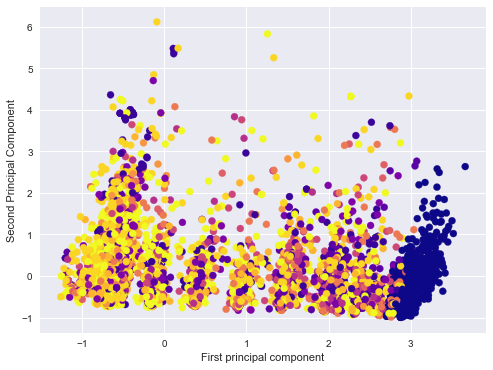

In [264]:
from sklearn.decomposition   import PCA;

pca = PCA(n_components=2);

pca.fit(X.toarray());

x_pca = pca.transform(X.toarray());

plt.figure(figsize=(8, 6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=y, cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10078
[t-SNE] Computed conditional probabilities for sample 2000 / 10078
[t-SNE] Computed conditional probabilities for sample 3000 / 10078
[t-SNE] Computed conditional probabilities for sample 4000 / 10078
[t-SNE] Computed conditional probabilities for sample 5000 / 10078
[t-SNE] Computed conditional probabilities for sample 6000 / 10078
[t-SNE] Computed conditional probabilities for sample 7000 / 10078
[t-SNE] Computed conditional probabilities for sample 8000 / 10078
[t-SNE] Computed conditional probabilities for sample 9000 / 10078
[t-SNE] Computed conditional probabilities for sample 10000 / 10078
[t-SNE] Computed conditional probabilities for sample 10078 / 10078
[t-SNE] Mean sigma: 1.358173
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.800509
[t-SNE] Error after 300 iterations: 0.800509


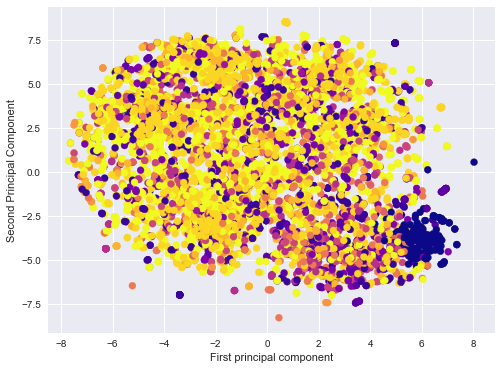

In [265]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

tsne_results = tsne.fit_transform(X.toarray())

plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y, cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

# How could we improve the event classifier?

- Use information about the time of day
- Use the location
- More intelligent feature design